# Process Crow et al. data
This notebook does the following:

1. Select template experiment. This template experiment will be used in the next [notebook](2_identify_generic_genes_pathways.ipynb) to simulate experiments with the same experimental design but testing a different biological process.

2. Crow et al. data was downloaded using `explore_RNAseq_only_generic_genes/download_Crow_data.R` script that downloads expression data from https://github.com/PavlidisLab/gemmaAPI.R

Note: For the analysis exploring the RNA-seq only common DEGs we used the union of genes per experiment, which resulted in some samples having NaNs for some samples. For this analysis we are taking the intersection so that we can remove all NaNs to train.

3. Train VAE on processed data.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Set seeds to get reproducible VAE trained models
process.set_all_seeds()

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [GSE11352](https://www.ncbi.nlm.nih.gov/gds/?term=GSE11352[Accession]) as the template experiment, which contains breast cell lines treated with estradiol at 12H, 24H and 48H.

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_Crow.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]

# Template experiment ID
project_id = params["project_id"]

# Column name containing sample ids
metadata_colname = params["metadata_colname"]

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params["shared_genes_filename"]

# Output files of template experiment data
mapped_template_filename = params["mapped_template_filename"]
processed_template_filename = params["processed_template_filename"]

# Output files of Rani's compendium data
raw_compendium_filename = params["raw_compendium_filename"]
mapped_compendium_filename = params["mapped_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params["scaler_filename"]

### Load compendium data

In [4]:
raw_compendium = pd.read_csv(raw_compendium_filename, sep="\t", header=0, index_col=0)
print(raw_compendium.shape)
raw_compendium.head()

(32476, 14487)


,HSPA6|HSPA7,UBA7,ESRRA,CYP2A7|CYP2A6,ADAM32,CORO6,CCDC65,LEAP2,CTCFL,C4orf33,...,TRIM15,NBL1|MICOS10-NBL1,GRK2,ATN1,FBXO41,KCTD13,TFEB,DND1,CASKIN2,GIMAP1-GIMAP5|GIMAP5
L_IB38___BioAssayId=72907Name=050705MJA_U133_2.0_IB08.CEL,8.96564,83.32761,48.94783,6.05333,17.74886,177.35550,22.08059,24.29061,NaN,57.44873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB40___BioAssayId=72909Name=050705MJA_U133_2.0_IB10.CEL,769.30450,61.90878,119.33116,17.42643,11.58205,117.40292,46.72446,50.81827,4.21085,29.51632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB41___BioAssayId=72910Name=050705MJA_U133_2.0_IB11.CEL,23.69639,93.37774,80.67838,27.73698,18.56551,175.07208,21.01308,56.90577,4.52370,70.19458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB33___BioAssayId=72902Name=050705MJA_U133_2.0_IB03.CEL,10.37628,56.58948,64.83450,14.86978,8.71849,41.07041,24.34623,62.00211,12.89886,38.07436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB36___BioAssayId=72905Name=050705MJA_U133_2.0_IB06.CEL,48.51214,41.29277,76.53021,15.66673,5.35315,27.70762,4.19627,13.33500,0.54027,14.19567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# raw_compendium.isna().sum()>0

In [6]:
# Samples with all NAs
# test = raw_compendium[raw_compendium.isna().sum(axis=1)== 14487]
# test

In [7]:
# test_remaining = raw_compendium.drop(test.index)

In [8]:
# test_remaining.isna().sum(axis=1).sort_values()

In [9]:
# test_remaining.isna().sum()

In [10]:
# x = raw_compendium.isna().sum()
# processed_compendium = raw_compendium[x.index[x<500]]

In [11]:
# Find samples with NaN
# processed_compendium = raw_compendium[raw_compendium.isna().sum(axis=1)<1]

In [12]:
# print(processed_compendium.shape)

In [13]:
# processed_compendium[processed_compendium.isna().sum(axis=1)<1]

In [14]:
# processed_compendium.loc["GSE17372_Biomat_204___BioAssayId=142015Name=2067.mAdbID.92564","ZSWIM2"] == -np.inf

### Process compendium data

1. Drop probe column
2. Transpose
3. Get only shared genes from Crow et. al.
4. Normalize

In [15]:
# Matrix is sample x gene
# Note, there are NaNs in the matrix. I'm not exactly sure what is causing this since the data
# downloaded was based on what Crow et al used in their analysis and therefore should have been
# filtered by platform.

# Filter out samples that are all NaNs ***
samples_to_drop = raw_compendium[
    raw_compendium.isna().sum(axis=1) == raw_compendium.shape[1]
].index
processed_compendium = raw_compendium.drop(samples_to_drop)
# processed_compendium = processed_compendium[processed_compendium.isna().sum(axis=1)<1]

# All genes have at least 1 NaN so dropping all genes with NaN removes all the data
# Instead we will move genes if they are NaN in _most_ samples (>90%)
x = processed_compendium.isna().sum()
processed_compendium = processed_compendium[x.index[x < 500]]

# Log transformed the data
processed_compendium = np.log10(processed_compendium)

# Replace -inf with 0
processed_compendium = processed_compendium.replace(-np.inf, 0.0)

# Get only gene expression data for genes in Crow et. al.
our_gene_ids_hgnc = list(processed_compendium.columns)

published_generic_genes = process.get_published_generic_genes(DE_prior_filename)
shared_genes_hgnc = list(set(our_gene_ids_hgnc).intersection(published_generic_genes))

# In Python, the order of elements in a list that is converted from a set
# is non-deterministic, so it is sorted here to have reproducible result.
shared_genes_hgnc.sort()

# Pickle `shared_genes_hgnc` and save as `shared_genes_filename`
if not os.path.exists(shared_genes_filename):
    with open(shared_genes_filename, "wb") as pkl_fh:
        pickle.dump(shared_genes_hgnc, pkl_fh)

mapped_compendium = processed_compendium[shared_genes_hgnc]
print(mapped_compendium.shape)
mapped_compendium.head(10)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


(32327, 9240)


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AA06,AAAS,AACS,...,ZSWIM2,ZSWIM3,ZSWIM5,ZSWIM6,ZSWIM8-AS1,ZW10,ZWINT,ZXDA,ZXDB,ZYG11A
L_IB38___BioAssayId=72907Name=050705MJA_U133_2.0_IB08.CEL,1.065841,NaN,2.830228,1.277496,0.934174,NaN,1.288853,1.385807,1.705279,2.149515,...,NaN,0.684421,1.829622,2.672289,NaN,1.854309,1.776283,1.571587,1.579250,NaN
L_IB40___BioAssayId=72909Name=050705MJA_U133_2.0_IB10.CEL,1.315443,NaN,2.772098,1.375198,0.955749,NaN,1.678347,1.149614,1.693465,1.795000,...,NaN,1.223080,1.282011,2.512385,NaN,1.832927,1.445187,1.515056,1.589636,NaN
L_IB41___BioAssayId=72910Name=050705MJA_U133_2.0_IB11.CEL,1.609360,NaN,3.029247,1.706261,0.920113,NaN,1.101758,1.170783,2.038132,2.376450,...,NaN,1.381539,1.821499,2.932263,NaN,1.946963,1.784327,1.825440,1.928628,NaN
L_IB33___BioAssayId=72902Name=050705MJA_U133_2.0_IB03.CEL,1.139712,NaN,3.132949,1.659614,0.929883,NaN,1.240478,1.275802,1.609121,1.997694,...,NaN,NaN,1.760609,2.924376,NaN,1.956613,1.712349,1.793429,1.906177,NaN
L_IB36___BioAssayId=72905Name=050705MJA_U133_2.0_IB06.CEL,1.136901,NaN,3.061634,1.665645,0.968267,NaN,1.357302,1.159235,-0.435962,1.839841,...,NaN,1.243580,1.641534,2.591005,NaN,1.726453,1.123409,1.624927,1.773889,NaN
L_IB59___BioAssayId=72912Name=051223MJA_U133_2.0_IB59.CEL,NaN,NaN,2.679757,1.486896,NaN,NaN,NaN,NaN,NaN,1.785735,...,NaN,NaN,NaN,2.703404,NaN,1.612601,1.253524,1.497435,1.588512,NaN
L_IB60___BioAssayId=72913Name=051223MJA_U133_2.0_IB60.CEL,NaN,NaN,2.866469,1.500284,NaN,NaN,1.334057,NaN,NaN,1.970829,...,NaN,NaN,1.638069,2.483739,NaN,1.867293,1.523012,1.416403,1.825827,NaN
L_IB17___BioAssayId=72886Name=050511MJA_U133_2.0_IB17.CEL,1.080051,NaN,3.239756,1.717509,NaN,NaN,1.371318,1.025251,0.501376,1.761094,...,NaN,0.616858,1.487186,2.630874,NaN,1.678493,1.004070,1.262583,1.477157,NaN
L_IB20___BioAssayId=72889Name=050511MJA_U133_2.0_IB20.CEL,0.344156,NaN,2.966025,1.870210,1.373515,NaN,1.318628,1.245711,1.533496,1.816991,...,NaN,0.881148,1.576671,2.922889,NaN,1.929145,1.702019,1.747574,1.942159,NaN
L_IB21___BioAssayId=72890Name=050511MJA_U133_2.0_IB21.CEL,0.572285,NaN,3.073107,1.781231,0.675340,NaN,1.544426,1.380718,1.495200,2.038555,...,NaN,1.269237,1.678406,2.892848,NaN,1.862019,1.355048,1.667296,1.859365,NaN


In [16]:
# Save
mapped_compendium.to_csv(mapped_compendium_filename, sep="\t")

In [17]:
# Normalize data
process.normalize_compendium(
    mapped_compendium_filename, normalized_compendium_filename, scaler_filename
)

In [18]:
# Check normalized data values
normalized_compendium = pd.read_csv(
    normalized_compendium_filename, sep="\t", index_col=0
)

In [19]:
normalized_compendium.head(10)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AA06,AAAS,AACS,...,ZSWIM2,ZSWIM3,ZSWIM5,ZSWIM6,ZSWIM8-AS1,ZW10,ZWINT,ZXDA,ZXDB,ZYG11A
L_IB38___BioAssayId=72907Name=050705MJA_U133_2.0_IB08.CEL,0.486,NaN,0.640,0.581,0.631,NaN,0.588,0.585,0.511,0.627,...,NaN,0.240,0.643,0.605,NaN,0.487,0.560,0.514,0.520,NaN
L_IB40___BioAssayId=72909Name=050705MJA_U133_2.0_IB10.CEL,0.537,NaN,0.628,0.596,0.635,NaN,0.672,0.533,0.508,0.549,...,NaN,0.388,0.510,0.574,NaN,0.482,0.510,0.500,0.522,NaN
L_IB41___BioAssayId=72910Name=050705MJA_U133_2.0_IB11.CEL,0.598,NaN,0.678,0.648,0.628,NaN,0.548,0.538,0.590,0.677,...,NaN,0.432,0.641,0.657,NaN,0.510,0.561,0.576,0.594,NaN
L_IB33___BioAssayId=72902Name=050705MJA_U133_2.0_IB03.CEL,0.501,NaN,0.698,0.641,0.630,NaN,0.578,0.561,0.488,0.594,...,NaN,NaN,0.626,0.655,NaN,0.512,0.550,0.569,0.589,NaN
L_IB36___BioAssayId=72905Name=050705MJA_U133_2.0_IB06.CEL,0.500,NaN,0.685,0.642,0.637,NaN,0.603,0.535,0.000,0.559,...,NaN,0.394,0.598,0.589,NaN,0.456,0.462,0.527,0.561,NaN
L_IB59___BioAssayId=72912Name=051223MJA_U133_2.0_IB59.CEL,NaN,NaN,0.611,0.614,NaN,NaN,NaN,NaN,NaN,0.547,...,NaN,NaN,NaN,0.612,NaN,0.429,0.481,0.496,0.522,NaN
L_IB60___BioAssayId=72913Name=051223MJA_U133_2.0_IB60.CEL,NaN,NaN,0.647,0.616,NaN,NaN,0.598,NaN,NaN,0.588,...,NaN,NaN,0.597,0.568,NaN,0.490,0.522,0.476,0.572,NaN
L_IB17___BioAssayId=72886Name=050511MJA_U133_2.0_IB17.CEL,0.489,NaN,0.719,0.650,NaN,NaN,0.606,0.506,0.224,0.542,...,NaN,0.222,0.560,0.597,NaN,0.445,0.444,0.438,0.499,NaN
L_IB20___BioAssayId=72889Name=050511MJA_U133_2.0_IB20.CEL,0.337,NaN,0.666,0.674,0.707,NaN,0.595,0.554,0.470,0.554,...,NaN,0.294,0.582,0.655,NaN,0.505,0.548,0.557,0.597,NaN
L_IB21___BioAssayId=72890Name=050511MJA_U133_2.0_IB21.CEL,0.384,NaN,0.687,0.660,0.586,NaN,0.643,0.583,0.461,0.603,...,NaN,0.401,0.606,0.649,NaN,0.489,0.496,0.538,0.580,NaN


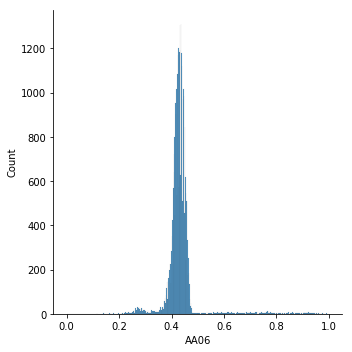

In [20]:
sns.displot(normalized_compendium["AA06"])

### Select and process template data

1. Get gene expression associated with `project_id`, which was manually selected by the user and specified in the config file.

Note: The data is not normalized so that we can perform DE analysis in next notebook

In [21]:
# Note: This is the only notebook using this function, so for now it is included here
# Get sample ids associated with selected project id
def get_sample_ids(experiment_id, mapping_filename):
    """
    Return sample ids for a given experiment id

    """
    # Read in metadata
    metadata = pd.read_csv(mapping_filename, header=0)
    metadata.set_index("Experiment id", inplace=True)

    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[metadata_colname])

    return sample_ids


# metadata file with mapping from experiment to sample
experiment_to_sample_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "experiment_sample_annotations.csv"
)

sample_ids = get_sample_ids(project_id, experiment_to_sample_metadata_filename)

# Get expression data
template_mapped = mapped_compendium.loc[sample_ids]
print(template_mapped.shape)

# Save
template_mapped.to_csv(mapped_template_filename, sep="\t")

(36, 9240)


### Train VAE

In [22]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]

NN_architecture = params["NN_architecture"]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

In [23]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)

input dataset contains 32327 samples and 9240 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 24245 samples, validate on 8082 samples
Epoch 1/10
24245/24245 [==============================] - 1978s 82ms/step - loss: nan - val_loss: nan
Epoch 2/10
  800/24245 [..............................] - ETA: 32:30 - loss: nan

KeyboardInterrupt: 